In [1]:
# Basic Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keras Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# sklearn imports
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import files
files.upload()  # Upload the 'kaggle.json' file
import os
# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json file to the correct location
!mv kaggle.json /root/.kaggle/
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
!unzip -q /content/face-expression-recognition-dataset.zip -d /content/
data_dir = '/content/images/'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown
 94% 113M/121M [00:00<00:00, 169MB/s] 
100% 121M/121M [00:00<00:00, 138MB/s]


In [3]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


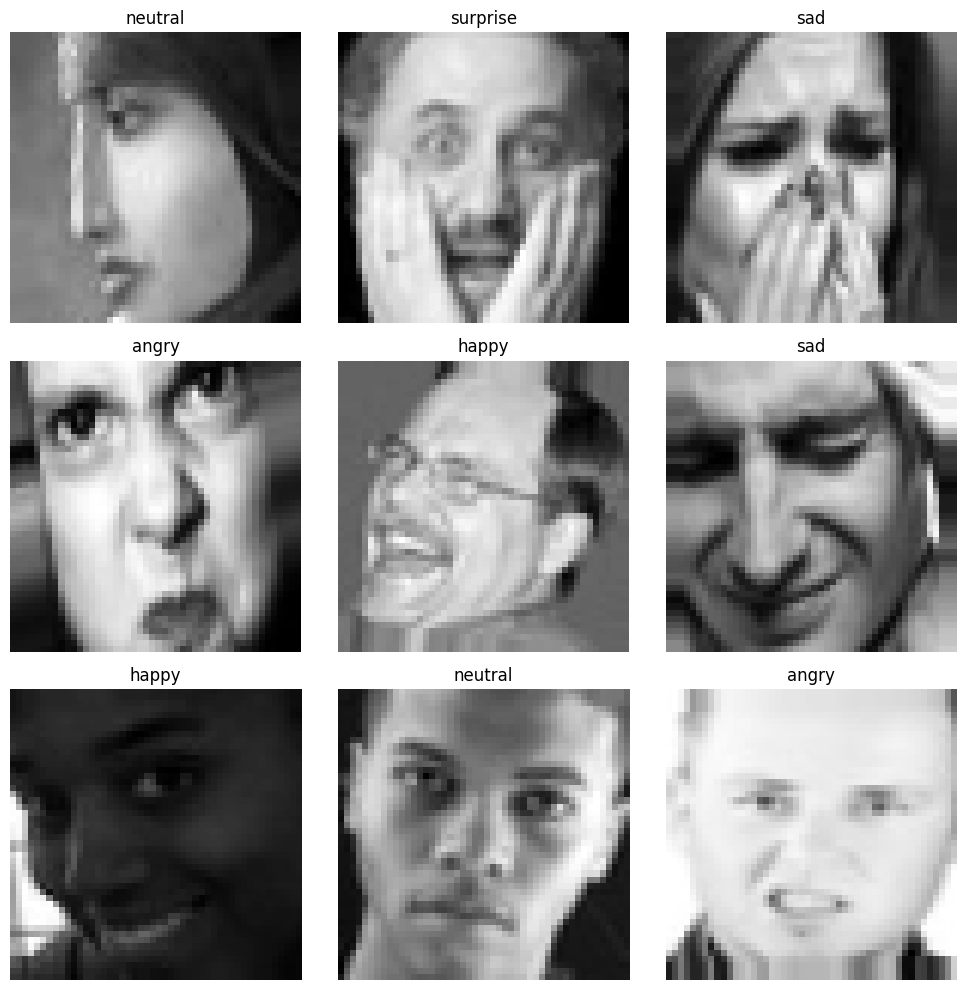

In [4]:
class_names = list(train_generator.class_indices.keys())

images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# 3. CNN Model Architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 46, 46, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,474,759 (9.44 MB)

 Trainable params: 2,472,839 (9.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Model Training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.2458 - loss: 2.3694 - val_accuracy: 0.2863 - val_loss: 2.1545 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.3671 - loss: 1.6860 - val_accuracy: 0.4382 - val_loss: 1.4534 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.4328 - loss: 1.4870 - val_accuracy: 0.4703 - val_loss: 1.3589 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4608 - loss: 1.3978 - val_accuracy: 0.4508 - val_loss: 1.4463 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.4753 - loss: 1.3666 - val_accuracy: 0.5052 - val_loss: 1.2781 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.4863 - loss: 1.3320 - val_accuracy: 0.5272 - val_loss: 1.2643 - learning_rate: 0.0010
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.5030 - loss: 1.3030

In [ ]:
#save model
model.save("model.h5")

#download model
files.download("model.h5")

In [ ]:
# 6. Evaluation - Classification Report & Confusion Matrix
val_images, val_labels = next(validation_generator)
predictions = model.predict(val_images)
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def detect_emotion(image_path):
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = round(prediction[0][predicted_index] * 100, 2)  # Confidence in %

    # Display the image with the predicted label and confidence
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Emotion: {predicted_class} ({confidence}%)')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence



In [ ]:
from google.colab import files
uploaded = files.upload()

# Assuming the uploaded file name is 'test_image.jpg'
image_path = next(iter(uploaded))  # Get the first uploaded file name
predicted_emotion, confidence = detect_emotion(image_path)
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")